# 1. Importing modules and functions

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm

In [4]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [5]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

## Load data and curation work set

In [7]:
# Set file path
df_ws=pd.read_csv('datasets/rat_oral_LD50_WS.csv')
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50
0,TOX-8327,12283,"6-methyl-1H-pyrimidine-2,4-dione",Cc1cc(=O)[nH]c(=O)[nH]1,Cc1cc(=O)[nH]c(=O)[nH]1,SHVCSCWHWMSGTE-UHFFFAOYSA-N,0.291207
1,TOX-27223,34042,"4-(1,3-benzodioxol-5-yl)butan-2-ylhydrazine",CC(CCc1ccc2c(c1)OCO2)NN,CC(CCc1ccc2c(c1)OCO2)NN,IBWPUTAKVGZXRB-UHFFFAOYSA-N,0.440661
2,TOX-5723,8058,hexane,CCCCCC,CCCCCC,VLKZOEOYAKHREP-UHFFFAOYSA-N,0.537456
3,TOX-72438,94201,"bis(2-ethylhexyl) cyclohexene-1,2-dicarboxylate",CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,ZVPBHZIVOWGPMT-UHFFFAOYSA-N,0.539248
4,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,0.580326
...,...,...,...,...,...,...,...
7869,TOX-34548,39729,"2,3,7,8-tetrabromodibenzo-p-dioxin",Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,JZLQUWSWOJPCAK-UHFFFAOYSA-N,6.698777
7870,TOX-2774,3890,"propan-2-yl 7-[3,5-dihydroxy-2-(3-hydroxy-5-ph...",CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,GGXICVAJURFBLW-UHFFFAOYSA-N,6.937118
7871,TOX-57286,3323,"5-[2-[7a-methyl-1-[7,7,7-trifluoro-6-hydroxy-6...",C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,XPYGGHVSFMUHLH-UHFFFAOYSA-N,7.099681
7872,TOX-6661,9426,"2-[(6,7-dimethoxy-1,2,3,4-tetrahydroisoquinoli...",CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,AUVVAXYIELKVAI-UHFFFAOYSA-N,7.602647


##  Standardization  for work set

In [9]:
df_ws["Molecule"] = df_ws.apply(lambda x: standart(x.Canonical_SMILES), axis=1)
print('Kept data: ', len(df_ws), 'molecules')

[11:25:17] Unusual charge on atom 8 number of radical electrons set to zero
[11:25:17] Unusual charge on atom 0 number of radical electrons set to zero
[11:25:17] Unusual charge on atom 16 number of radical electrons set to zero
[11:25:17] Unusual charge on atom 16 number of radical electrons set to zero


Kept data:  7874 molecules


In [10]:
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50,Molecule
0,TOX-8327,12283,"6-methyl-1H-pyrimidine-2,4-dione",Cc1cc(=O)[nH]c(=O)[nH]1,Cc1cc(=O)[nH]c(=O)[nH]1,SHVCSCWHWMSGTE-UHFFFAOYSA-N,0.291207,<rdkit.Chem.rdchem.Mol object at 0x0000020B54D...
1,TOX-27223,34042,"4-(1,3-benzodioxol-5-yl)butan-2-ylhydrazine",CC(CCc1ccc2c(c1)OCO2)NN,CC(CCc1ccc2c(c1)OCO2)NN,IBWPUTAKVGZXRB-UHFFFAOYSA-N,0.440661,<rdkit.Chem.rdchem.Mol object at 0x0000020B55D...
2,TOX-5723,8058,hexane,CCCCCC,CCCCCC,VLKZOEOYAKHREP-UHFFFAOYSA-N,0.537456,<rdkit.Chem.rdchem.Mol object at 0x0000020B55D...
3,TOX-72438,94201,"bis(2-ethylhexyl) cyclohexene-1,2-dicarboxylate",CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,ZVPBHZIVOWGPMT-UHFFFAOYSA-N,0.539248,<rdkit.Chem.rdchem.Mol object at 0x0000020B55D...
4,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,0.580326,<rdkit.Chem.rdchem.Mol object at 0x0000020B55D...
...,...,...,...,...,...,...,...,...
7869,TOX-34548,39729,"2,3,7,8-tetrabromodibenzo-p-dioxin",Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,JZLQUWSWOJPCAK-UHFFFAOYSA-N,6.698777,<rdkit.Chem.rdchem.Mol object at 0x0000020B54F...
7870,TOX-2774,3890,"propan-2-yl 7-[3,5-dihydroxy-2-(3-hydroxy-5-ph...",CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,GGXICVAJURFBLW-UHFFFAOYSA-N,6.937118,<rdkit.Chem.rdchem.Mol object at 0x0000020B54F...
7871,TOX-57286,3323,"5-[2-[7a-methyl-1-[7,7,7-trifluoro-6-hydroxy-6...",C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,XPYGGHVSFMUHLH-UHFFFAOYSA-N,7.099681,<rdkit.Chem.rdchem.Mol object at 0x0000020B54F...
7872,TOX-6661,9426,"2-[(6,7-dimethoxy-1,2,3,4-tetrahydroisoquinoli...",CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,AUVVAXYIELKVAI-UHFFFAOYSA-N,7.602647,<rdkit.Chem.rdchem.Mol object at 0x0000020B54F...


In [11]:
y_tr=df_ws.rat_oral_LD50	
y_tr

0       0.291207
1       0.440661
2       0.537456
3       0.539248
4       0.580326
          ...   
7869    6.698777
7870    6.937118
7871    7.099681
7872    7.602647
7873    9.541127
Name: rat_oral_LD50, Length: 7874, dtype: float64

In [12]:
df = pd.DataFrame(df_ws, columns=["SMILES"])
df

,SMILES
0,Cc1cc(=O)[nH]c(=O)[nH]1
1,CC(CCc1ccc2c(c1)OCO2)NN
2,CCCCCC
3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1
4,CC(O)CO
...,...
7869,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2
7870,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1
7871,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...
7872,CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...


In [13]:
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

In [14]:
moldf_ws=df_ws.Molecule

##  Load data and curation test set

In [16]:
df_ts=pd.read_csv('datasets/rat_oral_LD50_TS.csv')
df_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50
0,TOX-17137,297,methane,C,C,VNWKTOKETHGBQD-UHFFFAOYSA-N,0.017765
1,TOX-107853,17827,2-(cyclohexylamino)ethanol,OCCNC1CCCCC1,OCCNC1CCCCC1,MGUMZJAQENFQKN-UHFFFAOYSA-N,0.572835
2,TOX-44620,974,oxamic acid,NC(=O)C(=O)O,NC(=O)C(=O)O,SOWBFZRMHSNYGE-UHFFFAOYSA-N,0.624488
3,TOX-11368,62433,pentyl pentanoate,CCCCCOC(=O)CCCC,CCCCCOC(=O)CCCC,FGPPDYNPZTUNIU-UHFFFAOYSA-N,0.686956
4,TOX-7935,11429,"butane-1,2-diol",CCC(O)CO,CCC(O)CO,BMRWNKZVCUKKSR-UHFFFAOYSA-N,0.750711
...,...,...,...,...,...,...,...
1964,TOX-31209,123453,"N-(2,8,9-trioxa-5-aza-1-silabicyclo[3.3.3]unde...",c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,YGHSPISFNKUQEY-UHFFFAOYSA-N,5.931904
1965,TOX-63960,91771,"3-[3-[4-(4-bromophenyl)phenyl]-1,2,3,4-tetrahy...",O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,VSVAQRUUFVBBFS-UHFFFAOYSA-N,5.991624
1966,TOX-33005,38439,"1,2,3,7,8-pentachlorodibenzo-p-dioxin",Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,FSPZPQQWDODWAU-UHFFFAOYSA-N,6.238094
1967,TOX-24685,198007,3-ethyl-N-[methoxy(methylsulfanyl)phosphoryl]-...,CCN1CC(C)OC1=NP(=O)(OC)SC,CCN1CC(C)OC1=NP(=O)(OC)SC,JCYANUVOCLKHHY-UHFFFAOYSA-N,6.401876


##  Standardization  for test set

In [18]:
df_ts["Molecule"] = df_ts.apply(lambda x: standart(x.Canonical_SMILES), axis=1)
moldf_ts=df_ts[df_ts['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  1969 molecules


In [19]:
moldf_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50,Molecule
0,TOX-17137,297,methane,C,C,VNWKTOKETHGBQD-UHFFFAOYSA-N,0.017765,<rdkit.Chem.rdchem.Mol object at 0x0000020B54F...
1,TOX-107853,17827,2-(cyclohexylamino)ethanol,OCCNC1CCCCC1,OCCNC1CCCCC1,MGUMZJAQENFQKN-UHFFFAOYSA-N,0.572835,<rdkit.Chem.rdchem.Mol object at 0x0000020B55D...
2,TOX-44620,974,oxamic acid,NC(=O)C(=O)O,NC(=O)C(=O)O,SOWBFZRMHSNYGE-UHFFFAOYSA-N,0.624488,<rdkit.Chem.rdchem.Mol object at 0x0000020B55D...
3,TOX-11368,62433,pentyl pentanoate,CCCCCOC(=O)CCCC,CCCCCOC(=O)CCCC,FGPPDYNPZTUNIU-UHFFFAOYSA-N,0.686956,<rdkit.Chem.rdchem.Mol object at 0x0000020B55D...
4,TOX-7935,11429,"butane-1,2-diol",CCC(O)CO,CCC(O)CO,BMRWNKZVCUKKSR-UHFFFAOYSA-N,0.750711,<rdkit.Chem.rdchem.Mol object at 0x0000020B55D...
...,...,...,...,...,...,...,...,...
1964,TOX-31209,123453,"N-(2,8,9-trioxa-5-aza-1-silabicyclo[3.3.3]unde...",c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,YGHSPISFNKUQEY-UHFFFAOYSA-N,5.931904,<rdkit.Chem.rdchem.Mol object at 0x0000020B550...
1965,TOX-63960,91771,"3-[3-[4-(4-bromophenyl)phenyl]-1,2,3,4-tetrahy...",O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,VSVAQRUUFVBBFS-UHFFFAOYSA-N,5.991624,<rdkit.Chem.rdchem.Mol object at 0x0000020B550...
1966,TOX-33005,38439,"1,2,3,7,8-pentachlorodibenzo-p-dioxin",Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,FSPZPQQWDODWAU-UHFFFAOYSA-N,6.238094,<rdkit.Chem.rdchem.Mol object at 0x0000020B550...
1967,TOX-24685,198007,3-ethyl-N-[methoxy(methylsulfanyl)phosphoryl]-...,CCN1CC(C)OC1=NP(=O)(OC)SC,CCN1CC(C)OC1=NP(=O)(OC)SC,JCYANUVOCLKHHY-UHFFFAOYSA-N,6.401876,<rdkit.Chem.rdchem.Mol object at 0x0000020B550...


In [20]:
y_ts=moldf_ts.rat_oral_LD50
y_ts

0       0.017765
1       0.572835
2       0.624488
3       0.686956
4       0.750711
          ...   
1964    5.931904
1965    5.991624
1966    6.238094
1967    6.401876
1968    7.206791
Name: rat_oral_LD50, Length: 1969, dtype: float64

In [21]:
df_ts = pd.DataFrame(moldf_ts, columns=["SMILES"])
df_ts

,SMILES
0,C
1,OCCNC1CCCCC1
2,NC(=O)C(=O)O
3,CCCCCOC(=O)CCCC
4,CCC(O)CO
...,...
1964,c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1
1965,O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...
1966,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2
1967,CCN1CC(C)OC1=NP(=O)(OC)SC


In [20]:
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# Calculation Fingerprints for work set

In [21]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [22]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [23]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 6.Descriptor calculation for work set

In [24]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

## PubChem FPs

In [25]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'.csv']) 
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file,
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [53]:
descriptors_PubChem = pd.read_csv('PubChem.csv')

In [55]:
descriptors_PubChem

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_molecule_ws_1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,AUTOGEN_molecule_ws_7870,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7870,AUTOGEN_molecule_ws_7871,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7871,AUTOGEN_molecule_ws_7872,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7872,AUTOGEN_molecule_ws_7873,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df_RDKit_2D = descriptors_PubChem.drop('Name', axis=1)

In [61]:
x_tr = np.array(df_RDKit_2D, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [30]:
savetxt('models/Padels/x_tr_PubChem.csv', x_tr, delimiter=',')

In [45]:
x_tr.shape

(7874, 881)

# 7.Descriptor calculation for test set

In [32]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #PubChem.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, #'PubChem.csv'
                #descriptortypes='PubChem.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [68]:
descriptors_PubChem_ts = pd.read_csv('PubChem_ts.csv')

In [70]:
x_ts = descriptors_PubChem_ts.drop('Name', axis=1)

In [72]:
x_ts.shape

(1969, 881)

# CatBoostRegressor

In [74]:
cv=KFold(n_splits=5, random_state=42, shuffle=True)

In [76]:
%%time
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [100,500, 1000]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1, cv = cv)
grid.fit(x_tr, y_tr, verbose=False)

CPU times: total: 29min 7s
Wall time: 53min 18s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001CF3FD30860>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [77]:
best_CatBR = grid.best_estimator_

In [78]:
grid.best_params_

{'depth': 10, 'iterations': 1000, 'learning_rate': 0.1}

In [79]:
y_pred_ws_GBR = best_CatBR.predict(x_tr)

In [82]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.92

In [83]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.25

In [84]:
params={'verbose': False}

In [85]:
%%time
y_pred_CV_CatBR = cross_val_predict(best_CatBR, x_tr, y_tr, cv=cv, fit_params=params)

C:\Users\ovtti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


CPU times: total: 2h 24min 13s
Wall time: 11min 11s


In [86]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_CatBR), 2)
Q2_CV

0.58

In [87]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_CatBR)), 2)
RMSE_CV

0.58

# save the model to disk

In [103]:
pickle.dump(best_CatBR, open('Models/Padels/Toxicity_CatBoost_PubChem.pkl', 'wb'))

# load the model from disk

In [65]:
best_CatBR = pickle.load(open('Models/Padels/Toxicity_CatBoost_PubChem.pkl', 'rb'))

# 9. Prediction for test set's molecules

In [108]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [110]:
y_pred_GBR = best_CatBR.predict(x_ts)

In [112]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.6

In [114]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.56

# Calculate Feature Importance

In [67]:
data = pd.DataFrame({'feature_importance': best_CatBR.get_feature_importance(), 
              'feature_names': df_RDKit_2D.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

<Axes: ylabel='feature_names'>

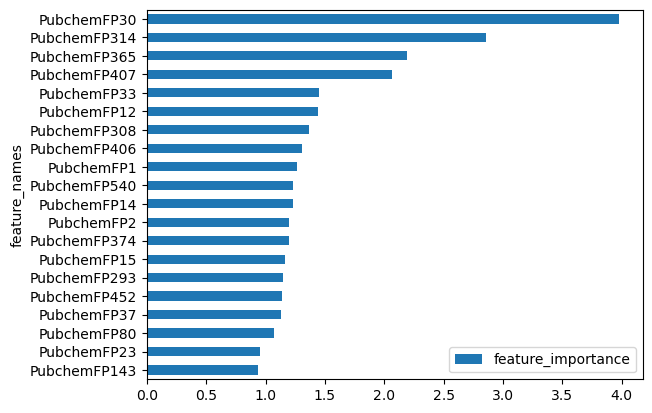

In [70]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

# 10. Y-randomization GradientBoostingRegressor model

In [124]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_CatBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           fit_params=params,
                                                           random_state=42)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

True score =  0.58 
Y-randomization =  -0.19 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [51]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [52]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.000000,4.472136,1.732051,3.000000,2.000000,2.645751,0.000000,3.162278,0.000000,1.000000,...,1.732051,2.449490,3.316625,4.582576,3.316625,4.358899,4.898980,3.000000,3.316625,3.605551
2,3.162278,4.690416,1.732051,3.872983,2.000000,3.000000,2.236068,3.741657,0.000000,2.000000,...,2.000000,2.645751,5.744563,5.196152,3.605551,5.196152,4.898980,3.162278,4.795832,3.605551
3,4.242640,5.291502,2.000000,4.123106,2.000000,3.162278,3.000000,3.741657,1.000000,2.236068,...,3.000000,3.316625,6.324555,5.385165,4.358899,5.291502,5.000000,4.123106,5.000000,3.741657
4,4.242640,5.291502,2.000000,4.242640,2.236068,3.162278,3.000000,4.000000,1.000000,2.236068,...,3.000000,3.316625,6.403124,5.656854,5.000000,5.385165,5.099020,4.358899,5.000000,4.242640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,14.730920,13.820275,14.832397,14.035668,14.798649,14.525839,14.696939,14.106736,14.317822,15.394804,...,14.933185,14.387495,14.387495,14.966630,14.933185,14.317822,13.711309,14.282857,14.071247,15.000000
7870,14.764823,13.856406,14.966630,14.071247,14.832397,14.594520,14.696939,14.177447,14.352700,15.459625,...,15.033297,14.594520,14.594520,15.099669,14.966630,14.352700,13.784049,14.282857,14.177447,15.000000
7871,14.798649,13.856406,15.132746,14.142136,14.933185,14.628738,14.764823,14.387495,14.456832,15.620500,...,15.165751,14.594520,14.628738,15.165751,15.099669,14.491377,13.820275,14.422205,14.317822,15.000000
7872,14.798649,13.892444,15.264338,14.177447,15.000000,14.730920,15.000000,14.525839,14.456832,15.748015,...,15.198684,14.594520,14.628738,15.362291,15.165751,14.560220,13.964240,14.491377,14.594520,15.165751


In [53]:
similarity= neighbors_k

In [54]:
Dmean=np.mean(similarity[1,:])

In [55]:
round(Dmean, 2)

2.77

In [56]:
std=np.std(similarity[1,:])

In [57]:
round(std, 2)

1.57

In [58]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.56


In [59]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [60]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,1.732051,2.645751,3.162278,1.000000,1.414214,1.732051,1.000000,2.449490,2.236068,3.605551,...,3.464102,5.916080,5.830952,2.000000,4.358899,3.741657,4.898980,1.414214,4.472136,3.162278
1,1.732051,3.162278,3.464102,1.414214,1.414214,2.000000,1.414214,4.123106,2.828427,3.605551,...,4.000000,7.549834,6.082763,3.316625,4.795832,4.123106,5.385165,3.316625,4.582576,4.358899
2,2.000000,3.605551,4.000000,1.732051,1.732051,2.000000,3.316625,4.242640,3.316625,3.741657,...,4.358899,7.615773,6.082763,4.358899,4.898980,4.123106,5.656854,4.358899,4.795832,5.000000
3,2.000000,3.605551,4.000000,1.732051,2.000000,2.449490,3.464102,4.472136,3.872983,3.741657,...,4.690416,7.810250,6.164414,4.582576,5.000000,4.472136,5.830952,4.472136,4.898980,5.099020
4,2.000000,3.741657,4.123106,1.732051,2.000000,2.645751,3.464102,4.690416,4.123106,3.872983,...,4.690416,7.810250,6.244998,4.690416,5.099020,4.690416,6.000000,4.582576,4.898980,5.196152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,15.066519,14.282857,14.764823,14.491377,14.730920,14.525839,14.628738,14.106736,14.662878,14.832397,...,14.832397,15.297058,13.266500,14.525839,14.933185,13.266500,14.866069,14.594520,14.696939,14.317822
7870,15.198684,14.282857,14.798649,14.560220,14.764823,14.628738,14.628738,14.142136,14.696939,14.933185,...,14.866069,15.362291,13.341664,14.662878,15.000000,13.341664,14.866069,14.662878,14.832397,14.387495
7871,15.362291,14.387495,14.899665,14.560220,14.866069,14.798649,14.730920,14.142136,14.730920,14.966630,...,14.899665,15.362291,13.379088,14.899665,15.033297,13.416408,14.966630,14.832397,14.866069,14.560220
7872,15.491934,14.456832,14.933185,14.696939,14.933185,14.933185,14.764823,14.282857,14.832397,15.132746,...,15.066519,15.394804,13.453624,14.966630,15.066519,13.601471,15.099669,14.899665,14.866069,14.628738


In [61]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.732 2.646 3.162 ... 1.414 4.472 3.162]


In [62]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [63]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.71


In [64]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1962 1966 1968]


In [65]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [66]:
y_pred_GBR_ad=list(y_pred_GBR)

In [67]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [68]:
len(y_pred_GBR_ad)

1398

In [69]:
y_ts_ad=list(y_ts)

In [70]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [71]:
len(y_ts_ad)

1398

In [72]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.68

In [73]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.52

# SVM model building and validation

In [74]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [75]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [76]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [77]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [78]:
svm.best_params_
best_svm = svm.best_estimator_

In [79]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [80]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [81]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.84

In [82]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.36

In [83]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [84]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.55

In [85]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.6

# 9. Prediction for test set's molecules

In [86]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [87]:
y_pred_svm = best_svm.predict(x_ts)

In [88]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.58

In [89]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.58

save the model to disk

In [90]:
pickle.dump(best_svm, open('models/Padels/Toxicity_SVM_PubChem.pkl', 'wb'))

load the model from disk

In [31]:
best_svm = pickle.load(open('models/Padels/Toxicity_SVM_PubChem.pkl', 'rb'))

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [91]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [92]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.000000,4.472136,1.732051,3.000000,2.000000,2.645751,0.000000,3.162278,0.000000,1.000000,...,1.732051,2.449490,3.316625,4.582576,3.316625,4.358899,4.898980,3.000000,3.316625,3.605551
2,3.162278,4.690416,1.732051,3.872983,2.000000,3.000000,2.236068,3.741657,0.000000,2.000000,...,2.000000,2.645751,5.744563,5.196152,3.605551,5.196152,4.898980,3.162278,4.795832,3.605551
3,4.242640,5.291502,2.000000,4.123106,2.000000,3.162278,3.000000,3.741657,1.000000,2.236068,...,3.000000,3.316625,6.324555,5.385165,4.358899,5.291502,5.000000,4.123106,5.000000,3.741657
4,4.242640,5.291502,2.000000,4.242640,2.236068,3.162278,3.000000,4.000000,1.000000,2.236068,...,3.000000,3.316625,6.403124,5.656854,5.000000,5.385165,5.099020,4.358899,5.000000,4.242640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,14.730920,13.820275,14.832397,14.035668,14.798649,14.525839,14.696939,14.106736,14.317822,15.394804,...,14.933185,14.387495,14.387495,14.966630,14.933185,14.317822,13.711309,14.282857,14.071247,15.000000
7870,14.764823,13.856406,14.966630,14.071247,14.832397,14.594520,14.696939,14.177447,14.352700,15.459625,...,15.033297,14.594520,14.594520,15.099669,14.966630,14.352700,13.784049,14.282857,14.177447,15.000000
7871,14.798649,13.856406,15.132746,14.142136,14.933185,14.628738,14.764823,14.387495,14.456832,15.620500,...,15.165751,14.594520,14.628738,15.165751,15.099669,14.491377,13.820275,14.422205,14.317822,15.000000
7872,14.798649,13.892444,15.264338,14.177447,15.000000,14.730920,15.000000,14.525839,14.456832,15.748015,...,15.198684,14.594520,14.628738,15.362291,15.165751,14.560220,13.964240,14.491377,14.594520,15.165751


In [93]:
similarity= neighbors_k

In [94]:
Dmean=np.mean(similarity[1,:])

In [95]:
round(Dmean, 2)

2.77

In [96]:
std=np.std(similarity[1,:])

In [97]:
round(std, 2)

1.57

In [98]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.56


In [99]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [100]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,1.732051,2.645751,3.162278,1.000000,1.414214,1.732051,1.000000,2.449490,2.236068,3.605551,...,3.464102,5.916080,5.830952,2.000000,4.358899,3.741657,4.898980,1.414214,4.472136,3.162278
1,1.732051,3.162278,3.464102,1.414214,1.414214,2.000000,1.414214,4.123106,2.828427,3.605551,...,4.000000,7.549834,6.082763,3.316625,4.795832,4.123106,5.385165,3.316625,4.582576,4.358899
2,2.000000,3.605551,4.000000,1.732051,1.732051,2.000000,3.316625,4.242640,3.316625,3.741657,...,4.358899,7.615773,6.082763,4.358899,4.898980,4.123106,5.656854,4.358899,4.795832,5.000000
3,2.000000,3.605551,4.000000,1.732051,2.000000,2.449490,3.464102,4.472136,3.872983,3.741657,...,4.690416,7.810250,6.164414,4.582576,5.000000,4.472136,5.830952,4.472136,4.898980,5.099020
4,2.000000,3.741657,4.123106,1.732051,2.000000,2.645751,3.464102,4.690416,4.123106,3.872983,...,4.690416,7.810250,6.244998,4.690416,5.099020,4.690416,6.000000,4.582576,4.898980,5.196152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,15.066519,14.282857,14.764823,14.491377,14.730920,14.525839,14.628738,14.106736,14.662878,14.832397,...,14.832397,15.297058,13.266500,14.525839,14.933185,13.266500,14.866069,14.594520,14.696939,14.317822
7870,15.198684,14.282857,14.798649,14.560220,14.764823,14.628738,14.628738,14.142136,14.696939,14.933185,...,14.866069,15.362291,13.341664,14.662878,15.000000,13.341664,14.866069,14.662878,14.832397,14.387495
7871,15.362291,14.387495,14.899665,14.560220,14.866069,14.798649,14.730920,14.142136,14.730920,14.966630,...,14.899665,15.362291,13.379088,14.899665,15.033297,13.416408,14.966630,14.832397,14.866069,14.560220
7872,15.491934,14.456832,14.933185,14.696939,14.933185,14.933185,14.764823,14.282857,14.832397,15.132746,...,15.066519,15.394804,13.453624,14.966630,15.066519,13.601471,15.099669,14.899665,14.866069,14.628738


In [101]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.732 2.646 3.162 ... 1.414 4.472 3.162]


In [102]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [103]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.71


In [104]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1962 1966 1968]


In [105]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [106]:
y_pred_svm_ad=list(y_pred_svm)

In [107]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [108]:
len(y_pred_svm_ad)

1398

In [109]:
y_ts_ad=list(y_ts)

In [110]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [111]:
len(y_ts_ad)

1398

In [112]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.67

In [113]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.54

# Multi-layer Perceptron regressor

In [114]:
from sklearn.neural_network import MLPRegressor

In [115]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [116]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [117]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [118]:
best_MLPR = m.best_estimator_

In [119]:
m.best_params_

{'activation': 'relu',
 'alpha': 5e-05,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 1000,
 'solver': 'adam'}

In [120]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [121]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.98

In [122]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.14

In [123]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [124]:
y_pred_CV_MLPR

array([1.1576469, 2.4739826, 1.2669187, ..., 6.29083  , 2.8630862,
       3.2266073], dtype=float32)

In [125]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.51

In [126]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.63

# 9. Prediction for test set's molecules

In [127]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [128]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [129]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.53

In [130]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.61

# save the model to disk

In [131]:
pickle.dump(best_MLPR, open('models/Padels/Toxicity_MLPR_PubChem.pkl', 'wb'))

# load the model from disk

In [87]:
best_MLPR = pickle.load(open('models/Padels/Toxicity_MLPR_PubChem.pkl', 'rb'))

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [132]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [133]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.000000,4.472136,1.732051,3.000000,2.000000,2.645751,0.000000,3.162278,0.000000,1.000000,...,1.732051,2.449490,3.316625,4.582576,3.316625,4.358899,4.898980,3.000000,3.316625,3.605551
2,3.162278,4.690416,1.732051,3.872983,2.000000,3.000000,2.236068,3.741657,0.000000,2.000000,...,2.000000,2.645751,5.744563,5.196152,3.605551,5.196152,4.898980,3.162278,4.795832,3.605551
3,4.242640,5.291502,2.000000,4.123106,2.000000,3.162278,3.000000,3.741657,1.000000,2.236068,...,3.000000,3.316625,6.324555,5.385165,4.358899,5.291502,5.000000,4.123106,5.000000,3.741657
4,4.242640,5.291502,2.000000,4.242640,2.236068,3.162278,3.000000,4.000000,1.000000,2.236068,...,3.000000,3.316625,6.403124,5.656854,5.000000,5.385165,5.099020,4.358899,5.000000,4.242640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,14.730920,13.820275,14.832397,14.035668,14.798649,14.525839,14.696939,14.106736,14.317822,15.394804,...,14.933185,14.387495,14.387495,14.966630,14.933185,14.317822,13.711309,14.282857,14.071247,15.000000
7870,14.764823,13.856406,14.966630,14.071247,14.832397,14.594520,14.696939,14.177447,14.352700,15.459625,...,15.033297,14.594520,14.594520,15.099669,14.966630,14.352700,13.784049,14.282857,14.177447,15.000000
7871,14.798649,13.856406,15.132746,14.142136,14.933185,14.628738,14.764823,14.387495,14.456832,15.620500,...,15.165751,14.594520,14.628738,15.165751,15.099669,14.491377,13.820275,14.422205,14.317822,15.000000
7872,14.798649,13.892444,15.264338,14.177447,15.000000,14.730920,15.000000,14.525839,14.456832,15.748015,...,15.198684,14.594520,14.628738,15.362291,15.165751,14.560220,13.964240,14.491377,14.594520,15.165751


In [134]:
similarity= neighbors_k

In [135]:
Dmean=np.mean(similarity[1,:])

In [136]:
round(Dmean, 2)

2.77

In [137]:
std=np.std(similarity[1,:])

In [138]:
round(std, 2)

1.57

In [139]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.56


In [140]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [141]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,1.732051,2.645751,3.162278,1.000000,1.414214,1.732051,1.000000,2.449490,2.236068,3.605551,...,3.464102,5.916080,5.830952,2.000000,4.358899,3.741657,4.898980,1.414214,4.472136,3.162278
1,1.732051,3.162278,3.464102,1.414214,1.414214,2.000000,1.414214,4.123106,2.828427,3.605551,...,4.000000,7.549834,6.082763,3.316625,4.795832,4.123106,5.385165,3.316625,4.582576,4.358899
2,2.000000,3.605551,4.000000,1.732051,1.732051,2.000000,3.316625,4.242640,3.316625,3.741657,...,4.358899,7.615773,6.082763,4.358899,4.898980,4.123106,5.656854,4.358899,4.795832,5.000000
3,2.000000,3.605551,4.000000,1.732051,2.000000,2.449490,3.464102,4.472136,3.872983,3.741657,...,4.690416,7.810250,6.164414,4.582576,5.000000,4.472136,5.830952,4.472136,4.898980,5.099020
4,2.000000,3.741657,4.123106,1.732051,2.000000,2.645751,3.464102,4.690416,4.123106,3.872983,...,4.690416,7.810250,6.244998,4.690416,5.099020,4.690416,6.000000,4.582576,4.898980,5.196152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,15.066519,14.282857,14.764823,14.491377,14.730920,14.525839,14.628738,14.106736,14.662878,14.832397,...,14.832397,15.297058,13.266500,14.525839,14.933185,13.266500,14.866069,14.594520,14.696939,14.317822
7870,15.198684,14.282857,14.798649,14.560220,14.764823,14.628738,14.628738,14.142136,14.696939,14.933185,...,14.866069,15.362291,13.341664,14.662878,15.000000,13.341664,14.866069,14.662878,14.832397,14.387495
7871,15.362291,14.387495,14.899665,14.560220,14.866069,14.798649,14.730920,14.142136,14.730920,14.966630,...,14.899665,15.362291,13.379088,14.899665,15.033297,13.416408,14.966630,14.832397,14.866069,14.560220
7872,15.491934,14.456832,14.933185,14.696939,14.933185,14.933185,14.764823,14.282857,14.832397,15.132746,...,15.066519,15.394804,13.453624,14.966630,15.066519,13.601471,15.099669,14.899665,14.866069,14.628738


In [142]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.732 2.646 3.162 ... 1.414 4.472 3.162]


In [143]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [144]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.71


In [145]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1962 1966 1968]


In [146]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [147]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [148]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [149]:
len(y_pred_MLPR_ad)

1398

In [150]:
y_ts_ad=list(y_ts)

In [151]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [152]:
len(y_ts_ad)

1398

In [153]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.64

In [154]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.56

# k-nearest neighbors

In [155]:
from sklearn.neighbors import KNeighborsRegressor

In [156]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [157]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [158]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [159]:
best_kNN = m.best_estimator_

In [160]:
m.best_params_

{'n_neighbors': 4}

In [161]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [162]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.69

In [163]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.5

In [164]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [165]:
y_pred_CV_kNN

array([1.5048168, 2.4437337, 1.7086506, ..., 3.2983975, 2.7180152,
       2.6280348], dtype=float32)

In [166]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.44

In [167]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.67

# 9. Prediction for test set's molecules

In [168]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [169]:
y_pred_kNN = best_kNN.predict(x_ts)

In [170]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.46

In [171]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.66

# save the model to disk

In [172]:
pickle.dump(best_kNN, open('models/Padels/Toxicity_kNN_PubChem.pkl', 'wb'))

# load the model from disk

In [212]:
best_kNN = pickle.load(open('models/Padels/Toxicity_kNN_PubChem.pkl', 'rb'))

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [173]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [174]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.000000,4.472136,1.732051,3.000000,2.000000,2.645751,0.000000,3.162278,0.000000,1.000000,...,1.732051,2.449490,3.316625,4.582576,3.316625,4.358899,4.898980,3.000000,3.316625,3.605551
2,3.162278,4.690416,1.732051,3.872983,2.000000,3.000000,2.236068,3.741657,0.000000,2.000000,...,2.000000,2.645751,5.744563,5.196152,3.605551,5.196152,4.898980,3.162278,4.795832,3.605551
3,4.242640,5.291502,2.000000,4.123106,2.000000,3.162278,3.000000,3.741657,1.000000,2.236068,...,3.000000,3.316625,6.324555,5.385165,4.358899,5.291502,5.000000,4.123106,5.000000,3.741657
4,4.242640,5.291502,2.000000,4.242640,2.236068,3.162278,3.000000,4.000000,1.000000,2.236068,...,3.000000,3.316625,6.403124,5.656854,5.000000,5.385165,5.099020,4.358899,5.000000,4.242640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,14.730920,13.820275,14.832397,14.035668,14.798649,14.525839,14.696939,14.106736,14.317822,15.394804,...,14.933185,14.387495,14.387495,14.966630,14.933185,14.317822,13.711309,14.282857,14.071247,15.000000
7870,14.764823,13.856406,14.966630,14.071247,14.832397,14.594520,14.696939,14.177447,14.352700,15.459625,...,15.033297,14.594520,14.594520,15.099669,14.966630,14.352700,13.784049,14.282857,14.177447,15.000000
7871,14.798649,13.856406,15.132746,14.142136,14.933185,14.628738,14.764823,14.387495,14.456832,15.620500,...,15.165751,14.594520,14.628738,15.165751,15.099669,14.491377,13.820275,14.422205,14.317822,15.000000
7872,14.798649,13.892444,15.264338,14.177447,15.000000,14.730920,15.000000,14.525839,14.456832,15.748015,...,15.198684,14.594520,14.628738,15.362291,15.165751,14.560220,13.964240,14.491377,14.594520,15.165751


In [175]:
similarity= neighbors_k

In [176]:
Dmean=np.mean(similarity[1,:])

In [177]:
round(Dmean, 2)

2.77

In [178]:
std=np.std(similarity[1,:])

In [179]:
round(std, 2)

1.57

In [180]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.56


In [181]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [182]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,1.732051,2.645751,3.162278,1.000000,1.414214,1.732051,1.000000,2.449490,2.236068,3.605551,...,3.464102,5.916080,5.830952,2.000000,4.358899,3.741657,4.898980,1.414214,4.472136,3.162278
1,1.732051,3.162278,3.464102,1.414214,1.414214,2.000000,1.414214,4.123106,2.828427,3.605551,...,4.000000,7.549834,6.082763,3.316625,4.795832,4.123106,5.385165,3.316625,4.582576,4.358899
2,2.000000,3.605551,4.000000,1.732051,1.732051,2.000000,3.316625,4.242640,3.316625,3.741657,...,4.358899,7.615773,6.082763,4.358899,4.898980,4.123106,5.656854,4.358899,4.795832,5.000000
3,2.000000,3.605551,4.000000,1.732051,2.000000,2.449490,3.464102,4.472136,3.872983,3.741657,...,4.690416,7.810250,6.164414,4.582576,5.000000,4.472136,5.830952,4.472136,4.898980,5.099020
4,2.000000,3.741657,4.123106,1.732051,2.000000,2.645751,3.464102,4.690416,4.123106,3.872983,...,4.690416,7.810250,6.244998,4.690416,5.099020,4.690416,6.000000,4.582576,4.898980,5.196152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,15.066519,14.282857,14.764823,14.491377,14.730920,14.525839,14.628738,14.106736,14.662878,14.832397,...,14.832397,15.297058,13.266500,14.525839,14.933185,13.266500,14.866069,14.594520,14.696939,14.317822
7870,15.198684,14.282857,14.798649,14.560220,14.764823,14.628738,14.628738,14.142136,14.696939,14.933185,...,14.866069,15.362291,13.341664,14.662878,15.000000,13.341664,14.866069,14.662878,14.832397,14.387495
7871,15.362291,14.387495,14.899665,14.560220,14.866069,14.798649,14.730920,14.142136,14.730920,14.966630,...,14.899665,15.362291,13.379088,14.899665,15.033297,13.416408,14.966630,14.832397,14.866069,14.560220
7872,15.491934,14.456832,14.933185,14.696939,14.933185,14.933185,14.764823,14.282857,14.832397,15.132746,...,15.066519,15.394804,13.453624,14.966630,15.066519,13.601471,15.099669,14.899665,14.866069,14.628738


In [183]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.732 2.646 3.162 ... 1.414 4.472 3.162]


In [184]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [185]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.71


In [186]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1962 1966 1968]


In [187]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [188]:
y_pred_kNN_ad=list(y_pred_kNN)

In [189]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [190]:
len(y_pred_kNN_ad)

1398

In [191]:
y_ts_ad=list(y_ts)

In [192]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [193]:
len(y_ts_ad)

1398

In [194]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.56

In [195]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.62

In [128]:
explainer = shap.Explainer(best_CatBR)

In [129]:
shap_values = explainer(x_tr)

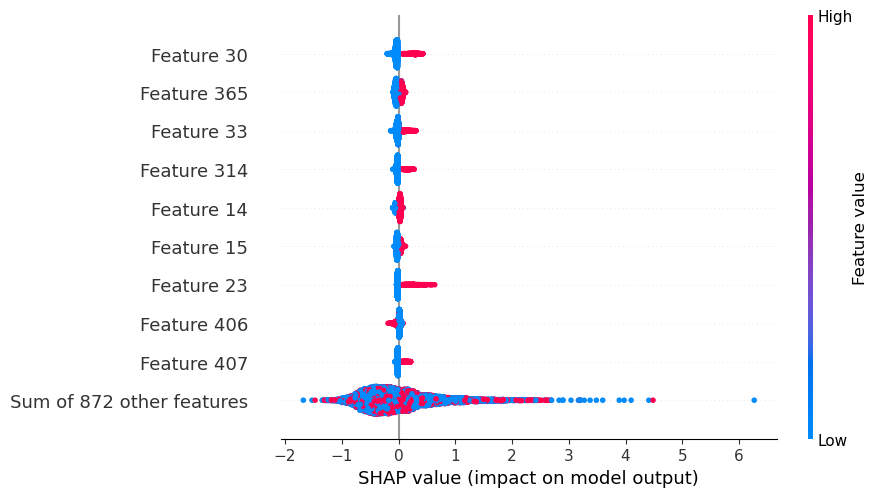

In [131]:
shap.plots.beeswarm(shap_values)

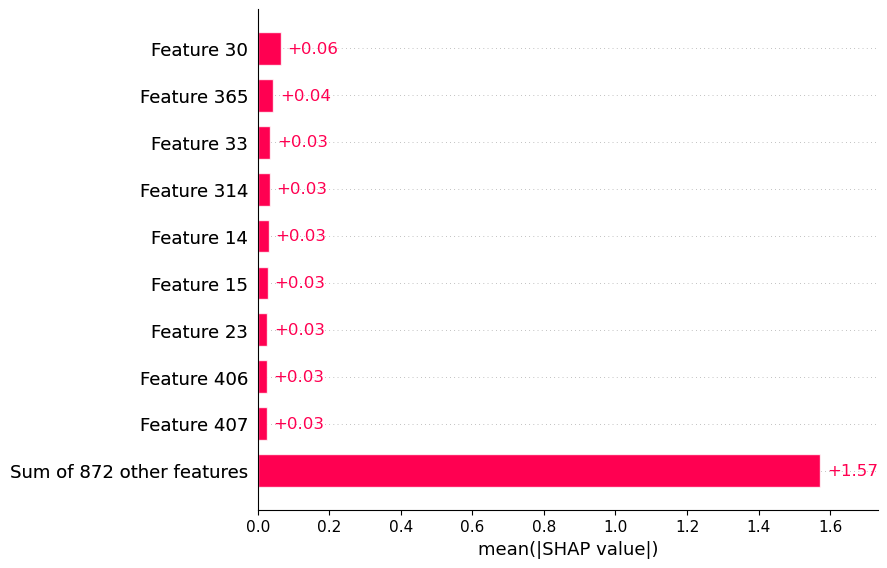

In [132]:
shap.plots.bar(shap_values)